# Vamos a comparar formas de clusterizar imágenes.

In [1]:
from datetime import datetime

from clasificacion_humedales.utils.clustering import best_reduction, graph_pca_results, clustering_with_best_bic, clustering_with_best_seed, graph_bic_clustering
from clasificacion_humedales.utils.utils_maia import save_clustering, load_from_file, directories, save_in_file, read_image, save_image

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

## Cargamos los datos

Datos de imágenes

In [2]:
PATH_IN, PATH_OUT = directories()
PATH_OUT += 'clustering/'

stack = read_image(PATH_IN + 'stack-ramsar.tif')

amount_of_images = stack.shape[0]
ancho = stack.shape[1]
alto = stack.shape[2]
cant_pixels_total = ancho * alto

stack_imagenes_estiradas = np.reshape(stack, (amount_of_images, cant_pixels_total))
stack_imagenes_estiradas.shape

(416, 189029)

Y también las fechas correspondientes a las mismas

In [3]:
metadata = pd.read_csv(PATH_IN + 'MYD13Q1-006-Statistics.csv')
dates = metadata['Date']
dates = [datetime.strptime(date, "%Y-%m-%d") for date in dates]

## Enmascaro

In [4]:
mask = stack_imagenes_estiradas[0]!=-3000
mask.sum()

45260

In [5]:
stack_mask = []
for i in range(len(stack_imagenes_estiradas)):
    stack_mask.append(stack_imagenes_estiradas[i][mask])
stack_mask = np.array(stack_mask).T

stack_mask.shape

(45260, 416)

In [6]:
assert((stack_mask == -3000).sum() == 0)

## Reducción de dimensionalidad

### PCA

Usamos PCA para reducir dimensionalidad. Probamos con distinta cantidad de componentes principales y vamos evaluando el score (la *likelihood*). Nos quedamos con la "rodilla".


In [7]:
X = stack_mask
dimensions = 21
n_components = np.arange(3, dimensions).tolist()

# result_pca = best_reduction(X, n_components)
# save_in_file(result_pca, PATH_OUT + 'result_pca')

result_pca = load_from_file(PATH_OUT + 'result_pca.pkl')

stack_pca = result_pca['best_reduction']

In [8]:
stack_pca.shape

(45260, 8)

In [9]:
#principal_components_images = np.transpose(reduced_stack_pca)
#for i in range(principal_components_images.shape[0]):
#    principal_component_i = np.reshape(principal_components_images[i], (ancho,alto))
#    save_image(PATH_IN + 'auxiliar.tif', PATH_OUT + '../componentes_principales' + 'reduced_stack_pca%s.tif' %i, principal_component_i)

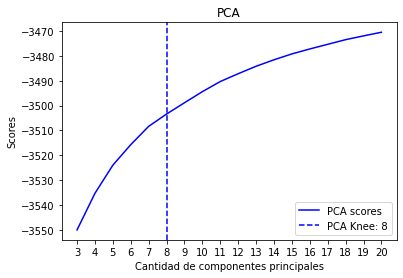

In [10]:
graph_pca_results(n_components, result_pca)

### Dates

También podemos reducir nuestra dimensionalidad calculando el promedio (o la mediana) y el desvío por cada mes.

In [11]:
def month(k):
    assert (k < 13)
    assert (k > 0)
    month = []
    for i in range(amount_of_images):
        if dates[i].month == k:
            month.append(stack_mask[:, i])
    return month


def mean_for_month(k):
    return np.mean(month(k), axis=0)


def standard_deviation_for_month(k):
    return np.std(month(k), axis=0)

In [12]:
stack_resumen_medias = [mean_for_month(i) for i in range(1, 13)]
stack_resumen_desvios = [standard_deviation_for_month(i) for i in range(1, 13)]
stack_dates = [*stack_resumen_medias, *stack_resumen_desvios]
stack_dates = np.asarray(stack_dates).transpose()
stack_dates.shape

(45260, 24)

In [13]:
# result_dates = {'best_reduction': stack_dates}
# save_in_file(result_dates, PATH_OUT + 'result_dates')

## Clustering con GMM

Para cada cantidad de clusters, iteramos 20 veces Gaussian Mixture Model. Promediamos los BIC scores y nos quedamos con la cantidad de componentes que tenga BIC más bajo. 


### PCA

In [14]:
n_clusters_range = np.arange(40, 69).tolist()
# clusters_with_pca = clustering_with_best_bic(stack_pca,n_clusters_range)
# save_in_file(clusters_with_pca, PATH_OUT + 'clusters_with_pca')

clusters_with_pca = load_from_file(PATH_OUT + 'clusters_with_pca.pkl')

Teniendo ese n lo volvemos a correr 20 veces y nos quedamos con la corrida que tenga el BIC menor.

In [15]:
best_n_components_pca = clusters_with_pca['best_n']
average_scores_pca = clusters_with_pca['average_bic_scores']

#best_clustering_pca = clustering_with_best_seed(stack_pca,best_n_components_pca)
#save_in_file(best_clustering_pca, PATH_OUT + 'best_clustering_pca')

best_clustering_pca = load_from_file(PATH_OUT + 'best_clustering_pca.pkl')

<AxesSubplot:xlabel='Cantidad de clusters', ylabel='BIC promedio'>

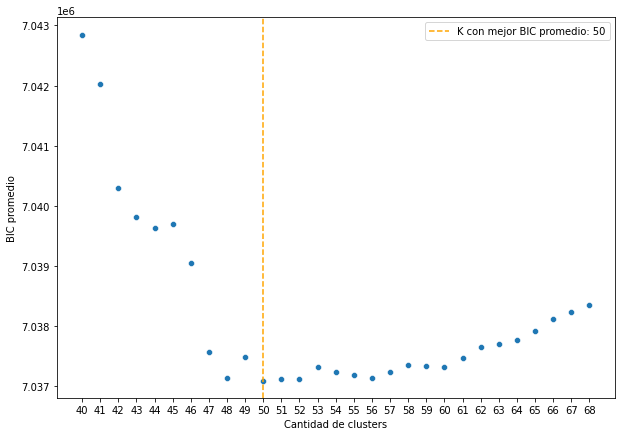

In [16]:
graph_bic_clustering(n_clusters_range, average_scores_pca, 'bic_pca')

### Dates

Ahora hacemos lo mismo pero con las fechas

In [17]:
n_clusters_range_dates = np.arange(5, 41).tolist()

#clusters_with_dates = clustering_with_best_bic(stack_dates,n_clusters_range_dates)
#save_in_file(clusters_with_dates, PATH_OUT + 'clusters_with_dates_mask')

clusters_with_dates = load_from_file(PATH_OUT + 'clusters_with_dates.pkl')

In [18]:
best_n_components_dates = clusters_with_dates['best_n']
average_scores_dates = clusters_with_dates['average_bic_scores']

# best_clustering_dates = clustering_with_best_seed(stack_dates,best_n_components_dates)
# save_in_file(best_clustering_dates, PATH_OUT + 'best_clustering_dates_mask')

best_clustering_dates = load_from_file(PATH_OUT + 'best_clustering_dates.pkl')

<AxesSubplot:xlabel='Cantidad de clusters', ylabel='BIC promedio'>

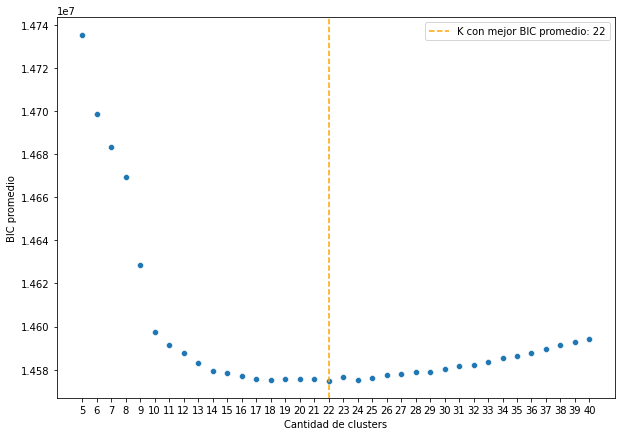

In [19]:
graph_bic_clustering(n_clusters_range_dates, clusters_with_dates['average_bic_scores'], 'bic_dates')

In [20]:
# clustering_5_components_dates = clustering_with_best_seed(stack_dates,5)
# save_in_file(clustering_5_components_dates, PATH_OUT + 'clustering_5_components_dates')
# clustering_5_components_dates = np.reshape(clustering_5_components_dates['cluster'],(ancho,alto))
# save_clustering(PATH_IN + 'auxiliar.tif', PATH_OUT + 'clustering_5_components_dates.tif', clustering_5_components_dates)

Guardamos nuestras imágenes para visualizarlas

In [21]:
# clustering_dates_estirado = stack_imagenes_estiradas[0].copy()
# clustering_dates_estirado[mask] = best_clustering_dates['cluster']
# clustering_dates_image = np.reshape(clustering_dates_estirado, (ancho, alto))
# save_clustering(PATH_IN + 'auxiliar-ramsar.tif', PATH_OUT + 'clustering_dates.tif', clustering_dates_image)

In [32]:
# clustering_pca_estirado = stack_imagenes_estiradas[0].copy()
# clustering_pca_estirado[mask] = best_clustering_pca['cluster']
# clustering_pca_image = np.reshape(clustering_pca_estirado, (ancho, alto))
# save_clustering(PATH_IN + 'auxiliar-ramsar.tif', PATH_OUT + 'clustering_pca.tif', clustering_pca_image)

## KMeans

In [12]:
X = stack_dates

n_clusters = 25

#cluster_labels = clustering_with_best_seed(X, n_clusters, covariance_type='spherical')
#save_in_file(cluster_labels, PATH_OUT+'kmeans')
cluster_labels = load_from_file(PATH_OUT+'kmeans.pkl')['cluster']

In [17]:
# Compute the silhouette scores for each sample

sample_silhouette_values = silhouette_samples(X, cluster_labels)

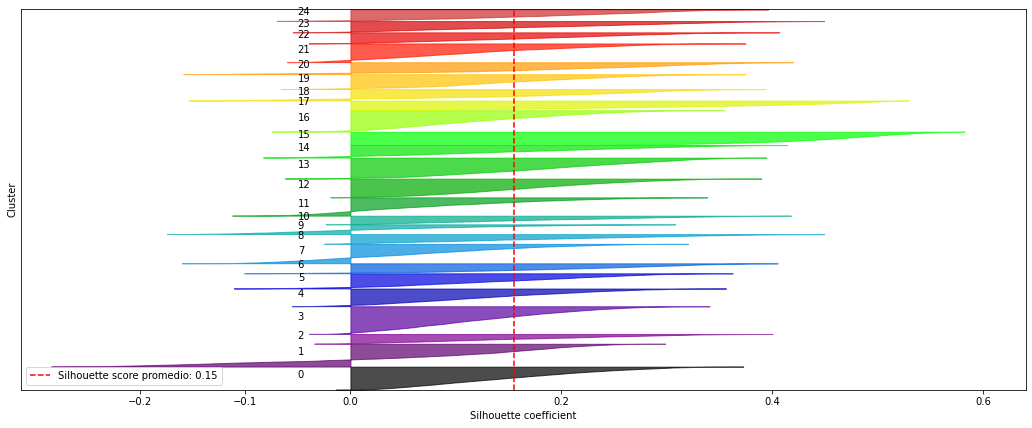

In [20]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)

ax.set_xlim([np.min(sample_silhouette_values)*1.1, np.max(sample_silhouette_values)*1.1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax.set_ylim([0, len(cluster_labels) + (n_clusters+1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = np.mean(sample_silhouette_values)

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Silhouette score promedio: {float(silhouette_avg):,.2f}')

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Cluster")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6])
plt.legend(loc='lower left')

plt.savefig(PATH_OUT + 'silhouette.png')

plt.show()